MEAN BASE: 0.5
LOGIT BASE: 0.7334971334971335


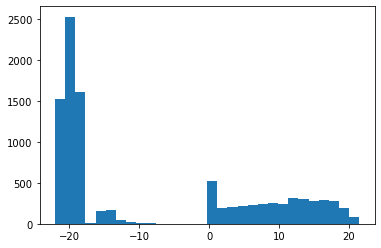

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

np.random.seed(109)

X_data = pd.read_csv('NHANESI_X.csv')
y_data = pd.read_csv('NHANESI_y.csv')

X_data = X_data.drop('Unnamed: 0', axis = 1)
y_data = y_data.drop('Unnamed: 0', axis = 1)

plt.hist(x=y_data.values, bins=30)
y_data['y'] = (abs(y_data['y'])>=18)*1

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2,  random_state = 109, shuffle=True, stratify=y_data['y']
)

X_data.head()
y_data.head()

combined = pd.concat([X_data, y_data], axis = 1)

combined_dropped = combined.dropna()

X_data_dropped = combined_dropped[['Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']]
y_data_dropped = combined_dropped[['y']]

imputer = KNNImputer(n_neighbors=1)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

X_train_impute = pd.DataFrame(X_train_imputed, columns = X_data.columns)
X_test_impute = pd.DataFrame(X_test_imputed, columns = X_data.columns)

y_train = pd.DataFrame(y_train.values, columns = y_data.columns)
y_test = pd.DataFrame(y_test.values, columns = y_data.columns)

train_imputed = pd.concat([X_train_impute, y_train], axis = 1)
test_imputed = pd.concat([X_test_impute, y_test], axis = 1)

train_imputed.head()

X_train_impute.columns

train_sex = X_train_impute['Sex'].subtract(1)
X_train_impute['Sex'] = train_sex

test_sex = X_test_impute['Sex'].subtract(1)
X_test_impute['Sex'] = test_sex

train_race = X_train_impute['Race'].subtract(1)
X_train_impute['Race'] = train_race

test_race = X_test_impute['Race'].subtract(1)
X_test_impute['Race'] = test_race

X_train_impute.head()
scaler = StandardScaler()

# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(interaction_only=True)
# X_train_poly_reg = scaler.fit_transform(poly.fit_transform(X_train_impute))
# X_test_poly_reg = scaler.fit_transform(poly.fit_transform(X_test_impute))

# Baseline KNN regression model on dropped data
baseline_kNN_model = KNeighborsClassifier(n_neighbors=len(X_train_impute)).fit(X_train_impute,y_train.values.ravel())
y_pred = baseline_kNN_model.predict(X_test_impute)

X_train_impute = scaler.fit_transform(X_train_impute)
X_test_impute = scaler.fit_transform(X_test_impute)

baseline_kNN_model_accuracy = roc_auc_score(y_test, y_pred)
print(f"MEAN BASE: {baseline_kNN_model_accuracy}")

# Logistic regression model on dropped data
logit_base = LogisticRegression(max_iter=100000).fit(X_train_impute,y_train.values.ravel())
y_pred = logit_base.predict(X_test_impute)

logit_base_test_accuracy = roc_auc_score(y_test, y_pred)
print(f"LOGIT BASE: {logit_base_test_accuracy}")

## k-NN:

In [2]:
# Cross-Validated kNN Classification - Vineet
# include plots of training and validation accuracy maybe

k_list = [1,2,3,4,5,7,10,15,20,25,40,50,75,80,100]

validation_error = []
training_error = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_impute, y_train.values.ravel())
    
    accuracies = cross_validate(knn, X_train_impute, y_train.values.ravel(), scoring = "roc_auc", cv=5, return_train_score=True)

    # Compute the validation errors got after cross validation
    train_acc = accuracies['train_score'].mean()
    val_acc =  accuracies['test_score'].mean()
    
    # Append the Accuracies to their respective lists     
    validation_error.append(val_acc)
    training_error.append(train_acc)
    
    

In [3]:
max_val = max(validation_error)
k = k_list[validation_error.index(max_val)]
print(k)

100


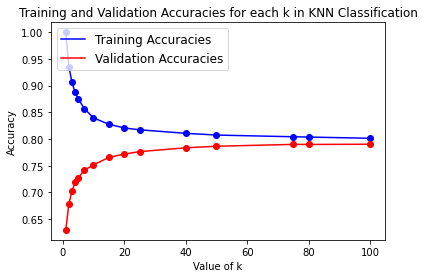

In [4]:
# scatter plot and line for training acc
plt.scatter(k_list,training_error, color="b")
plt.plot(k_list,training_error, color="b", label="Training Accuracies")

# scatter plot and line for val acc
plt.scatter(k_list,validation_error, color="r")
plt.plot(k_list,validation_error, color="r", label="Validation Accuracies")

# Labels, axes, and legend
plt.title("Training and Validation Accuracies for each k in KNN Classification")
plt.xlabel("Value of k")
plt.ylabel("Accuracy")
plt.legend(loc = 'upper left', fontsize = 12)

In [5]:
best_knn = KNeighborsClassifier(n_neighbors=k)
best_knn.fit(X_train_impute, y_train.values.ravel())

y_test_pred = best_knn.predict(X_test_impute)

best_knn_test_acccuracy = roc_auc_score(y_test, y_test_pred)

print("The overall test classification accuracy as a percentage is: ", round(best_knn_test_acccuracy,6))


The overall test classification accuracy as a percentage is:  0.686036


## Logistic Regression with Lasso

In [6]:
logit_lasso = LogisticRegression(penalty = 'l1', max_iter = 500, solver ='saga')

logit_lasso.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train = logit_lasso.predict(X_train_impute)
    
y_pred_test = logit_lasso.predict(X_test_impute)
    
logit_lasso_train_accuracy = roc_auc_score(y_train, y_pred_train)
logit_lasso_test_accuracy = roc_auc_score(y_test, y_pred_test)

print("Logistic regression lasso train accuracy: ")
print(logit_lasso_train_accuracy)
print("\nLogistic regression lasso test accuracy: ")
print(logit_lasso_test_accuracy)

Logistic regression lasso train accuracy: 
0.7345790546437102

Logistic regression lasso test accuracy: 
0.7326706872161418


## CV Logistic Regression with Lasso

In [7]:
Cs_vals = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]

logit_lasso_CV = LogisticRegressionCV(penalty = 'l1', scoring="roc_auc", Cs=Cs_vals, cv = 5, max_iter = 2000, solver ='liblinear')

logit_lasso_CV.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train_CV = logit_lasso_CV.predict(X_train_impute)
    
y_pred_test_CV = logit_lasso_CV.predict(X_test_impute)
    
logit_lasso_train_accuracy_CV = roc_auc_score(y_train, y_pred_train_CV)
logit_lasso_test_accuracy_CV = roc_auc_score(y_test, y_pred_test_CV)

print("Logistic regression CV lasso train accuracy: ")
print(logit_lasso_train_accuracy_CV)
print("\nLogistic regression CV lasso test accuracy: ")
print(logit_lasso_test_accuracy_CV)


Logistic regression CV lasso train accuracy: 
0.7344757061525982

Logistic regression CV lasso test accuracy: 
0.7334971334971335


## Logistic Regression with Ridge Regularization

In [8]:
logit_ridge = LogisticRegression(penalty = 'l2', max_iter = 10000, solver = 'lbfgs')

logit_ridge.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train = logit_ridge.predict(X_train_impute)
    
y_pred_test = logit_ridge.predict(X_test_impute)
    
logit_ridge_train_accuracy = roc_auc_score(y_train, y_pred_train)
logit_ridge_test_accuracy = roc_auc_score(y_test, y_pred_test)

print("Logistic regression ridge train accuracy: ")
print(logit_ridge_train_accuracy)
print("\nLogistic regression ridge test accuracy: ")
print(logit_ridge_test_accuracy)


Logistic regression ridge train accuracy: 
0.7343147792134286

Logistic regression ridge test accuracy: 
0.7334971334971335


## CV Logistic Regression with Ridge Regularization

In [9]:
Cs_vals = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]

logit_ridge_CV = LogisticRegressionCV(penalty = 'l2', scoring="roc_auc", Cs=Cs_vals, max_iter = 10000, cv = 5, solver = 'lbfgs')

logit_ridge_CV.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train_CV = logit_ridge.predict(X_train_impute)
    
y_pred_test_CV = logit_ridge.predict(X_test_impute)
    
logit_ridge_train_accuracy_CV = roc_auc_score(y_train, y_pred_train_CV)
logit_ridge_test_accuracy_CV = roc_auc_score(y_test, y_pred_test_CV)

print("Logistic regression CV ridge train accuracy: ")
print(logit_ridge_train_accuracy_CV)
print("\nLogistic regression CV ridge test accuracy: ")
print(logit_ridge_test_accuracy_CV)

Logistic regression CV ridge train accuracy: 
0.7343147792134286

Logistic regression CV ridge test accuracy: 
0.7334971334971335


## Single Decision Tree (CV)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

depths = list(range(1, 51))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        dtree = DecisionTreeClassifier(max_depth=depth)
        dtree.fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring="roc_auc")
        train_scores.append(train_score)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train_impute, y_train.values.ravel(), depths)


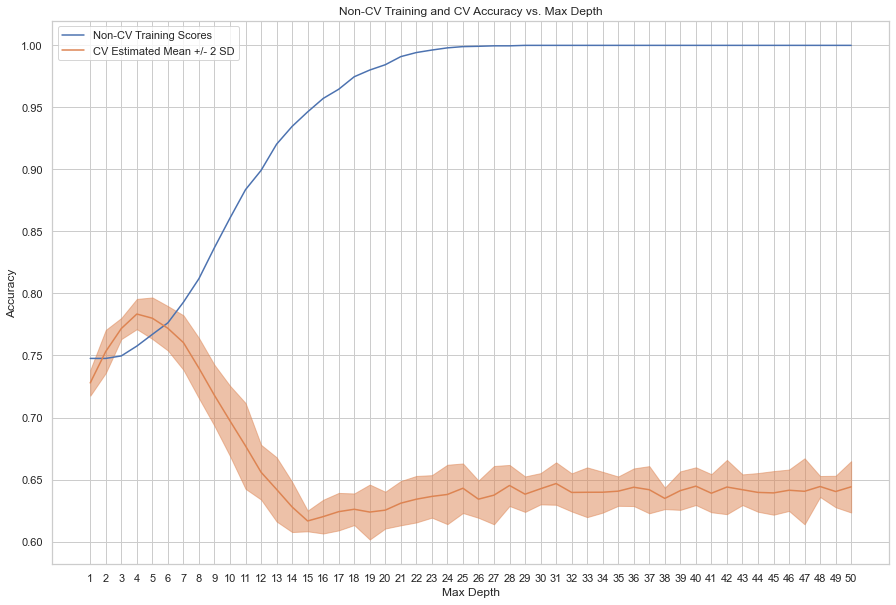

In [11]:
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

plt.figure(figsize=(15,10))
plt.plot(depths, train_scores, label="Non-CV Training Scores")
plt.plot(depths, cvmeans, label="CV Estimated Mean +/- 2 SD")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, color="C1", alpha=0.5)
plt.legend()
plt.title("Non-CV Training and CV Accuracy vs. Max Depth")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);


In [12]:
dtree_5 = DecisionTreeClassifier(max_depth=4).fit(X_train_impute, y_train.values.ravel())
tree_train_pred = dtree_5.predict(X_train_impute)
tree_test_pred = dtree_5.predict(X_test_impute)

best_cv_tree_train_score = roc_auc_score(y_train, tree_train_pred)
best_cv_tree_test_score = roc_auc_score(y_test, tree_test_pred)
display((best_cv_tree_train_score, best_cv_tree_test_score))



(0.72794133398121, 0.7088957316230045)

## Decision Trees with Bagging

In [13]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # your code here
    
    bagging_train_df = pd.DataFrame()
    bagging_test_df = pd.DataFrame()
    bagging_models = []
    
    for i in range(n_trees):
        boot = train_imputed.sample(frac=1, replace=True)
        X_train_boot = boot.iloc[:, boot.columns != "y"].values
        y_train_boot = boot["y"].values
        
        dtree = DecisionTreeClassifier(max_depth=tree_depth, random_state=random_seed)
        dtree.fit(X_train_boot, y_train_boot)
        
        bagging_train_df[f"bootstrap model {i + 1}'s prediction"] = dtree.predict(X_train_impute)
        bagging_test_df[f"bootstrap model {i + 1}'s prediction"] = dtree.predict(X_test_impute)
    
    bagging_models.append(dtree)
    
    return bagging_train_df, bagging_test_df, bagging_models


In [14]:

tree_depth = 5
model_count = 1

bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees=model_count, tree_depth=tree_depth)
bagging_train_df["Aggregated Output"] = bagging_train_df.mode(axis=1)
bagging_test_df["Aggregated Output"] = bagging_test_df.mode(axis=1)

bag_train_pred = bagging_train_df["Aggregated Output"]
bag_test_pred = bagging_test_df["Aggregated Output"] 

# train_correct = (bagging_train_df["Aggregated Output"] == y_train.values.ravel()) 
# bagging_accuracy_train = train_correct.sum() / train_correct.size

# test_correct = (bagging_test_df["Aggregated Output"] == y_test.values.ravel())
# bagging_accuracy_test = test_correct.sum() / test_correct.size

bagging_accuracy_train = roc_auc_score(y_train, bag_train_pred)
bagging_accuracy_test = roc_auc_score(y_test, bag_test_pred)

print(f"Bagging Model Train Accuracy: {bagging_accuracy_train}") 
print(f"Bagging Model Test Accuracy: {bagging_accuracy_test}")

Bagging Model Train Accuracy: 0.5
Bagging Model Test Accuracy: 0.5


In [16]:
from sklearn.ensemble import BaggingClassifier

tree_depth = 5
model_count = 1

bagging_model = BaggingClassifier(DecisionTreeClassifier(max_depth=tree_depth, random_state=69), n_estimators = 120)

bagging_model.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train = bagging_model.predict(X_train_impute)
    
y_pred_test = bagging_model.predict(X_test_impute)
    
bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)

print("Bagging model train accuracy: ")
print(bagging_model_train_accuracy)
print("\nBagging model test accuracy: ")
print(bagging_model_test_accuracy)



Bagging model train accuracy: 
0.7530828252836379

Bagging model test accuracy: 
0.7220497356860994


In [17]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    
    n_trees = prediction_dataset.shape[1]
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    running_conclusions = running_percent_1s > 0.5
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    return np.mean(running_correctnesss, axis=0)

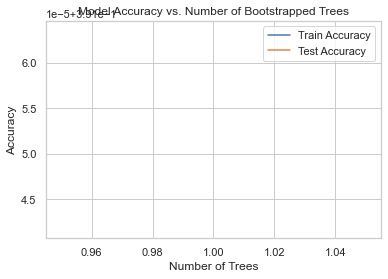

In [18]:
train_score = running_predictions(bagging_train_df[bagging_train_df.columns[:-1]].to_numpy(), y_train.values.ravel())
test_score = running_predictions(bagging_test_df[bagging_test_df.columns[:-1]].to_numpy(), y_test.values.ravel())

num_trees = list(range(1, model_count + 1))

plt.plot(num_trees, train_score, label = "Train Accuracy")
plt.plot(num_trees, test_score, label = "Test Accuracy")
plt.legend()
plt.title("Model Accuracy vs. Number of Bootstrapped Trees")
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")
ylim = plt.ylim()

## Boosting

Text(0, 0.5, 'staged score')

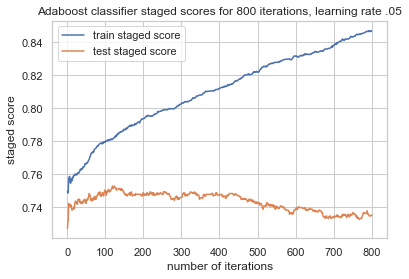

In [19]:
# Boosting - Vineet
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.05, n_estimators=800)
boost.fit(X_train_impute, y_train.values.ravel())

boost_train_staged_score = list(boost.staged_score(X_train_impute,y_train.values.ravel()))
boost_test_staged_score = list(boost.staged_score(X_test_impute,y_test.values.ravel()))

plt.plot(range(1,801), boost_train_staged_score, label = "train staged score")
plt.plot(range(1,801), boost_test_staged_score, label = "test staged score")
plt.title("Adaboost classifier staged scores for 800 iterations, learning rate .05")
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("staged score")

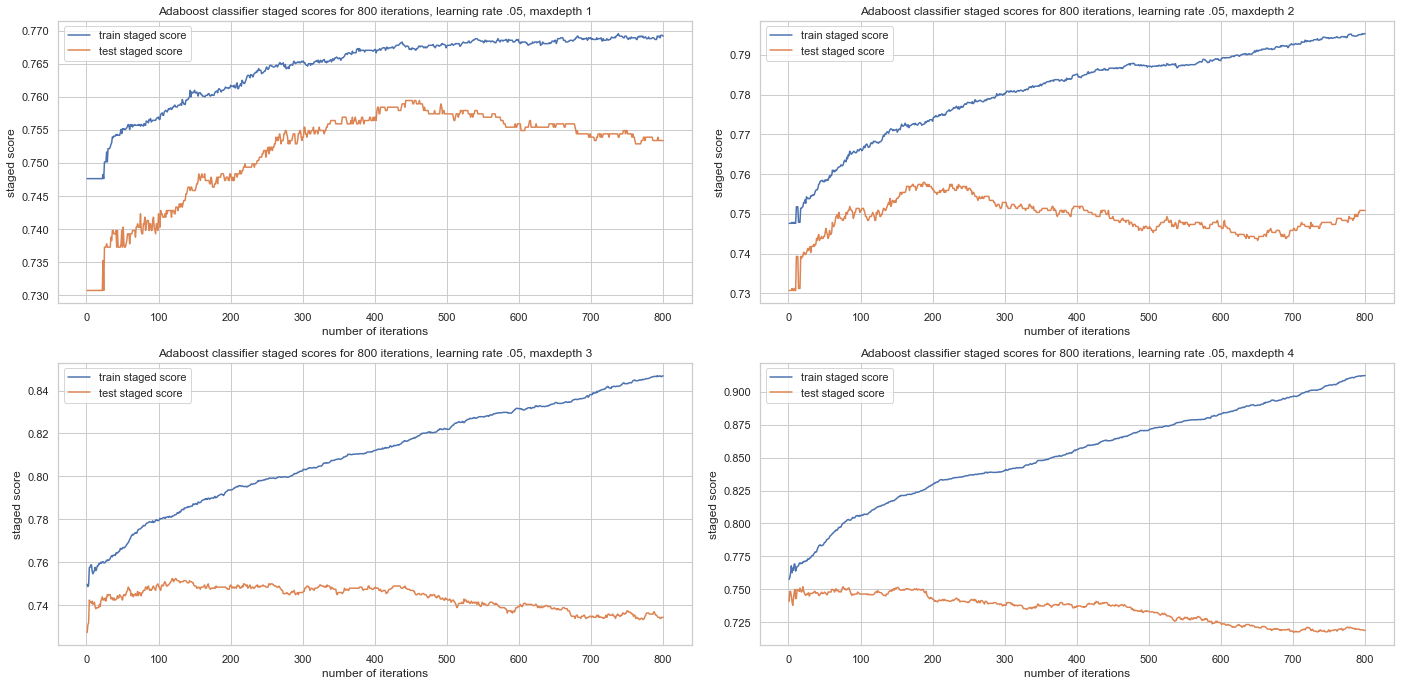

In [20]:
depths = [1,2,3,4]
fig, axs = plt.subplots(2,2, figsize=(20,10))

fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i in range(len(depths)):
    boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depths[i]), learning_rate=0.05, n_estimators=800)
    boost.fit(X_train_impute,y_train.values.ravel())

    boost_train_staged_score = list(boost.staged_score(X_train_impute,y_train.values.ravel()))
    boost_test_staged_score = list(boost.staged_score(X_test_impute,y_test.values.ravel()))

    axs[i].plot(range(1,801), boost_train_staged_score, label = "train staged score")
    axs[i].plot(range(1,801), boost_test_staged_score, label = "test staged score")
    axs[i].set_title("Adaboost classifier staged scores for 800 iterations, learning rate .05, maxdepth " + str(depths[i]))
    axs[i].legend()
    axs[i].set_xlabel("number of iterations")
    axs[i].set_ylabel("staged score")


In [21]:
boost_depth3 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.05, n_estimators=120)
boost_depth3.fit(X_train_impute,y_train.values.ravel())

boost_depth3_train_score = boost_depth3.score(X_train_impute,y_train.values.ravel())
boost_depth3_test_score = boost_depth3.score(X_test_impute,y_test.values.ravel())

boost_depth3_train_score, boost_depth3_test_score

(0.7814977973568282, 0.7523905385002516)

## Random Forest

In [22]:
## Random Forest - Sean
## grid search with 5-fold cross-validation
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

#hyperF = dict(n_estimators = [500], max_depth = [5, 8, 15, 25, 35],
#             min_samples_split = [2, 5, 10, 15, 50])
#gridF = GridSearchCV(RandomForestClassifier(random_state = 69), hyperF, cv = 5, verbose = 1, n_jobs = -1)
#bestF = gridF.fit(X_train_impute, y_train.values.ravel())
#bestF.best_estimator_

# should get min_samples_split = 50, max_depth = 15, min_samples_leaf default?


In [23]:
from sklearn.ensemble import RandomForestClassifier

# fit the random forest with extracted hyperparameters
rf = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_split = 15, random_state = 69)
rf.fit(X_train_impute, y_train.values.ravel())

# test accuracy
y_pred = rf.predict(X_test_impute)
rf_test_accuracy = roc_auc_score(y_test, y_pred)


In [24]:
print(f"random forest test accuracy is {rf_test_accuracy}")

random forest test accuracy is 0.7321154684791048


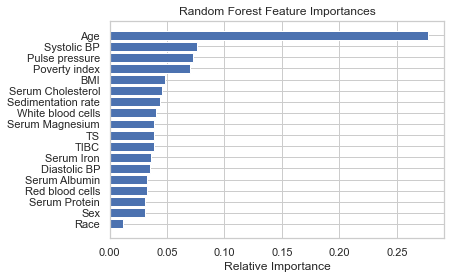

In [25]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title("Random Forest Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [28]:
conda install -c conda-forge shap

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\seana\anaconda3\envs\cs109a

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    llvmlite-0.35.0            |   py37habb0c8c_0        15.1 MB  conda-forge
    numba-0.52.0               |   py37h08fd248_0         3.6 MB  conda-forge
    shap-0.36.0                |   py37h414f9d2_0         490 KB  conda-forge
    slicer-0.0.3               |             py_0          14 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        19.2 MB

The following NEW packages will be INSTALLED:

  llvmlite           conda-forge/win-64::llvmlite-0.35.0-py37habb0c8c_0
  numba              conda-forge/win-64::numba-0.52.0-py37h08fd248_0
  shap               conda-forge/win-64::shap-0.36.0-py37h414f9d



==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda




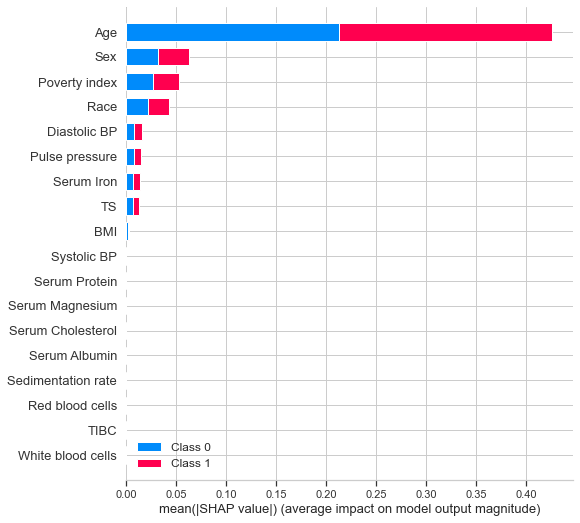

In [29]:
import shap
X_train_impute = pd.DataFrame(X_train_impute, columns = X_train.columns)
shap_values_dtree_5 = shap.TreeExplainer(dtree_5).shap_values(X_train_impute)
shap.summary_plot(shap_values_dtree_5, X_train_impute, plot_type="bar", alpha=0.5)



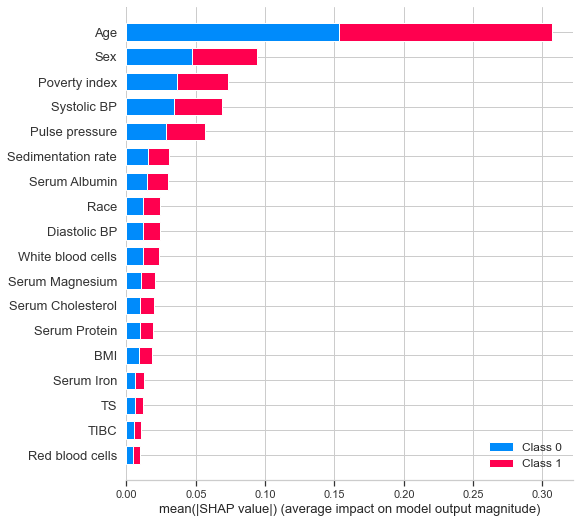

In [30]:
shap_values_dtree_5 = shap.TreeExplainer(rf).shap_values(X_train_impute)
shap.summary_plot(shap_values_dtree_5, X_train_impute, plot_type="bar", alpha=0.5)



In [31]:
shap_values_logit = shap.Explainer(logit_base).shap_values(X_train_impute)
shap.summary_plot(shap_values_logit, X_train_impute, plot_type="bar", alpha=0.5)



TypeError: __init__() missing 1 required positional argument: 'masker'

In [ ]:
### Inlcude permutation importance